# Regularization

https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

Lets look at  the impact of model complexity on the magnitude of coefficients. As an example, we simulate a sine curve (between 60° and 300°) and add some random noise using the following code:

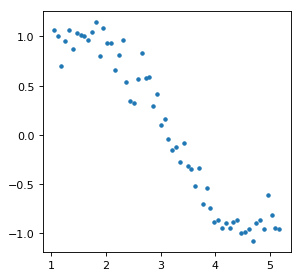

In [20]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])

from matplotlib.pyplot import figure
figure(figsize=(4,4), dpi=80)
plt.plot(data['x'],data['y'],'.')
plt.show()

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios. Let’s try to estimate the sine function using polynomial regression with powers of x from 1 to 15. Let’s add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [21]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

    x    y  x_2  x_3  x_4  x_5  x_6  x_7  x_8  x_9  x_10  x_11  x_12  x_13  \
0   1  1.1  1.1  1.1  1.2  1.3  1.3  1.4  1.4  1.5   1.6   1.7   1.7   1.8   
1 1.1    1  1.2  1.4  1.6  1.7  1.9  2.2  2.4  2.7     3   3.4   3.8   4.2   
2 1.2  0.7  1.4  1.7    2  2.4  2.8  3.3  3.9  4.7   5.5   6.6   7.8   9.3   
3 1.3 0.95  1.6    2  2.5  3.1  3.9  4.9  6.2  7.8   9.8    12    16    19   
4 1.3  1.1  1.8  2.3  3.1  4.1  5.4  7.2  9.6   13    17    22    30    39   

   x_14  x_15  
0   1.9     2  
1   4.7   5.3  
2    11    13  
3    24    31  
4    52    69  


Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – ( model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [24]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models.  

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code:

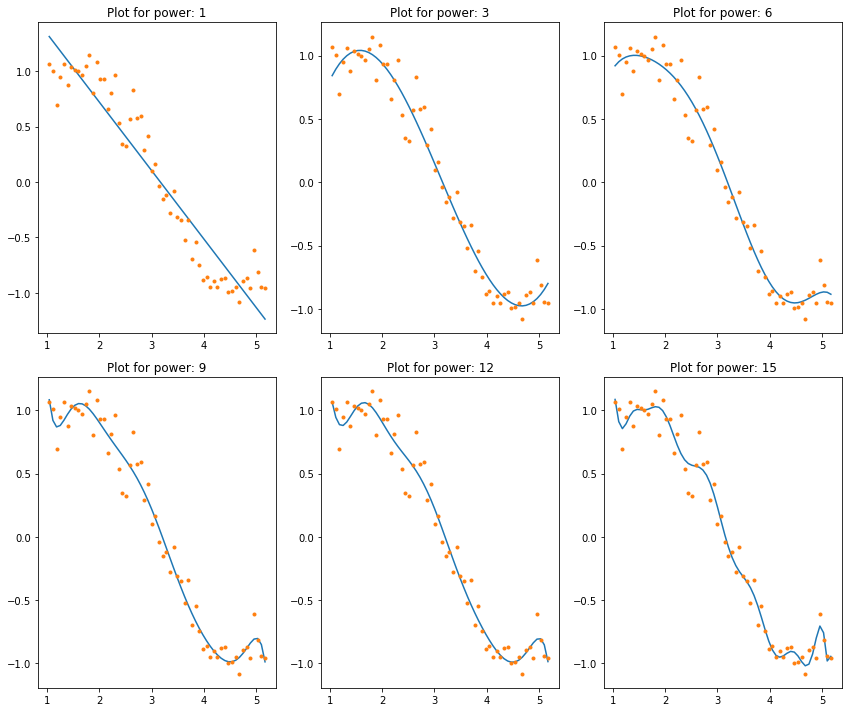

In [25]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [26]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


It is clearly evident that the size of coefficients increase exponentially with increase in model complexity. I hope this gives some intuition into why putting a constraint on the magnitude of coefficients can be a good idea to reduce model complexity.

What does a large coefficient signify? It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.
 
 Now, lets look at ridge and lasso regression in detail and see how well they work for the same problem.
 #### In the following we are using function "Ridge" that we import from sklearn.linear_model
 #### The following function is just defined to plot different models with different regularization parameters. 

In [27]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model 
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

#### First, lets define a generic function for ridge regression similar to the one defined for simple linear regression.
#### Here Alpha is the regularization parameter.  In the slides we used Lambda. 

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.82892e-17): result may not be accurate.
  overwrite_a=True).T


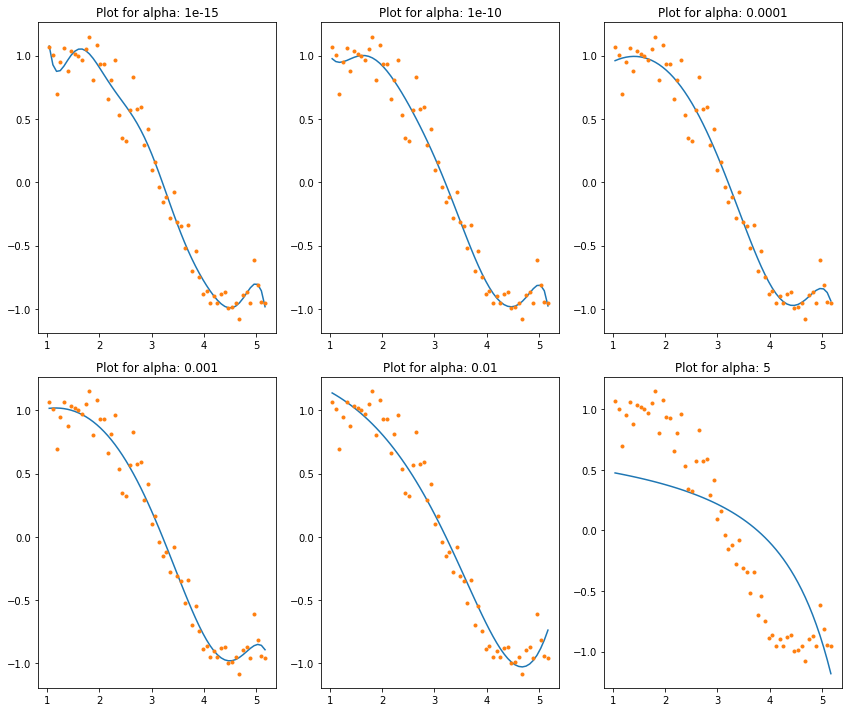

In [28]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

Note that each of these 10 models will contain all the 15 variables and only the value of alpha would differ. This is different from the simple linear regression case where each model had a subset of features.

In [29]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,94,-3e+02,3.8e+02,-2.4e+02,68,-1.3,-3.7,0.3,0.19,-0.021,-0.0076,0.0011,0.00024,-6.3e-05,4.5e-06,-8.7e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13
